In [1]:
import numpy as np
import math
import random
from tqdm import tqdm
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(y, y_hat):
    return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

def gradients(X, y, y_hat):
    partial_w = (X.T.dot(y_hat - y)) / X.shape[0] 
    partial_b = np.sum(y_hat - y) / X.shape[0]
    
    return partial_w, partial_b

def train(X, y, bs, epochs, lr):
    # bs :  batch size
    m, n = X.shape

    w = np.zeros((n, 1))
    b = 0

    y = y.reshape(m, 1)
    x = normalize(X)

    best_w = None
    best_b = None
    best_loss = float("inf")
    losses = []

    for _ in tqdm(range(epochs)):
        for i in range((m - 1) // bs + 1):
            start_idx = i * bs
            end_idx = start_idx + bs
        
            x_batch = x[start_idx: end_idx]
            y_batch = y[start_idx: end_idx]

            pred = sigmoid(x_batch.dot(w) + b)
            partial_w, partial_b = gradients(x_batch, y_batch, pred)

            w -= lr * partial_w
            b -= lr * partial_b

        losses.append(loss(y, sigmoid(X.dot(w) + b)))

        if losses[-1] < best_loss:
            best_w = w
            best_b = b

    return best_w, best_b, losses

def normalize(X):
    # Replace std == 0 with std == 1 to allow normalization of columns with 0 std values
    return (X - X.mean(axis=0)) / np.where(X.std(axis=0)==0, np.ones(X.std(axis=0).shape[0]), X.std(axis=0))

def predict(X):
    x = normalize(X)
    return np.array([int(i > 0.5) for i in sigmoid(x.dot(w) + b)])

def accuracy(y, y_hat):
    return np.sum(y == y_hat) / len(y)

In [3]:
def confusion_matrix(ytrue, ypred, labels):
    output = {i:0 for i in itertools.product(labels, labels)}
    
    for idx, val in enumerate(ytrue):
        output[(val, ypred[idx])] += 1

    return output

In [4]:
def f1_score(y, y_hat):
    cm = confusion_matrix(y, y_hat, [0, 1])
    return cm[(1, 1)] / (cm[(1, 1)] + 0.5 * (cm[(0, 1)] + cm[(1, 0)]))

In [5]:
def stats(y, y_pred):
    print(f"Accuracy: {accuracy(y, y_pred)}")
    print(f"Confusion Matrix: {confusion_matrix(y, y_pred, [0, 1])}")
    print(f"F1 Score: {f1_score(y, y_pred)}")
    print()

In [6]:
def knn_pca(train_X, test_X, train_y, n_components):
    knn = make_pipeline(StandardScaler(), PCA(n_components=n_components), KNeighborsClassifier(n_neighbors=2))
    knn.fit(train_X, train_y)
    stats(train_y, knn.predict(train_X))
    write_submission_file(f"knn_pca_{n_components}", test_ids, knn.predict(test_X))


In [7]:
def log_reg_pca(train_X, test_X, train_y, n_components):
    logreg = make_pipeline(StandardScaler(), PCA(n_components=n_components), LogisticRegression(solver="saga", penalty="elasticnet", random_state=42, max_iter=200, n_jobs=5, l1_ratio=0.5))
    logreg.fit(train_X, train_y)
    stats(train_y, logreg.predict(train_X))
    write_submission_file(f"log_reg_pca_{n_components}", test_ids, logreg.predict(test_X))


In [8]:
def write_submission_file(filename, id, prediction):
    data = [",".join([str(j) for j in i]) for i in zip(id, prediction)]
    data.insert(0, "id,label")
    if filename[-4:] != ".csv":
        filename += ".csv"
    with open("predictions/" + filename, "w") as fp:
        fp.write("\n".join(data))

In [9]:
train_df = pd.read_csv("train_tfidf_features.csv", header=0).dropna()
#train_df = train_df.loc[:, train_df.std() > 0]
train_ids = train_df["id"].to_numpy()
train_y = train_df["label"].to_numpy()
train_X = train_df.drop(["id", "label"], axis=1).to_numpy()

In [10]:
test_df = pd.read_csv("test_tfidf_features.csv", header=0).dropna()
#test_df = test_df.loc[:, test_df.std() > 0]
test_ids = test_df["id"].to_numpy()
test_X = test_df.drop(["id"], axis=1).to_numpy()

In [11]:
w, b, l = train(train_X, train_y, bs=2000, epochs=200, lr=0.01)
stats(train_y, predict(train_X))

100%|██████████| 200/200 [05:38<00:00,  1.69s/it]


Accuracy: 0.8524208566108007
Confusion Matrix: {(0, 0): 9604, (0, 1): 1029, (1, 0): 1507, (1, 1): 5044}
F1 Score: 0.7991128010139417



In [12]:
clf = make_pipeline(StandardScaler(), LogisticRegression()).fit(train_X, train_y)
stats(train_y, clf.predict(train_X))
write_submission_file("skl_log_reg_pred.csv", test_ids, clf.predict(test_X))

c:\Users\Razer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8732541899441341
Confusion Matrix: {(0, 0): 9687, (0, 1): 946, (1, 0): 1232, (1, 1): 5319}
F1 Score: 0.8300561797752809



In [58]:
write_submission_file("LogRed_Prediction.csv", test_ids, predict(test_X))

In [13]:
# KNN baseline
knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=2))
knn.fit(train_X, train_y)
stats(train_y, knn.predict(train_X))

Accuracy: 0.8200069832402235
Confusion Matrix: {(0, 0): 10630, (0, 1): 3, (1, 0): 3090, (1, 1): 3461}
F1 Score: 0.691163255117324



In [16]:
# 5000 components as sanity check to make sure I'm not screwing the implementation up
for i in [5000, 4000, 3000, 2000, 1000, 500, 100]:
    print(f"n_components: {i}")
    log_reg_pca(train_X, test_X, train_y, i)

n_components: 5000


c:\Users\Razer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.8709264432029795
Confusion Matrix: {(0, 0): 9691, (0, 1): 942, (1, 0): 1276, (1, 1): 5275}
F1 Score: 0.8262844611528822

n_components: 4000


c:\Users\Razer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.8430516759776536
Confusion Matrix: {(0, 0): 9499, (0, 1): 1134, (1, 0): 1563, (1, 1): 4988}
F1 Score: 0.7871853546910755

n_components: 3000


c:\Users\Razer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.8137220670391061
Confusion Matrix: {(0, 0): 9354, (0, 1): 1279, (1, 0): 1922, (1, 1): 4629}
F1 Score: 0.7430772935227546

n_components: 2000
Accuracy: 0.7811336126629422
Confusion Matrix: {(0, 0): 9198, (0, 1): 1435, (1, 0): 2326, (1, 1): 4225}
F1 Score: 0.6919990172795021

n_components: 1000
Accuracy: 0.7494762569832403
Confusion Matrix: {(0, 0): 9134, (0, 1): 1499, (1, 0): 2806, (1, 1): 3745}
F1 Score: 0.6350148367952523

n_components: 500
Accuracy: 0.7255004655493482
Confusion Matrix: {(0, 0): 9033, (0, 1): 1600, (1, 0): 3117, (1, 1): 3434}
F1 Score: 0.5928355632283124

n_components: 100
Accuracy: 0.6872090316573557
Confusion Matrix: {(0, 0): 9164, (0, 1): 1469, (1, 0): 3906, (1, 1): 2645}
F1 Score: 0.4960150023441163



In [17]:
# 5000 components as sanity check to make sure I'm not screwing the implementation up
for i in [5000, 4000, 3000, 2000, 1000, 500, 100]:
    print(f"n_components: {i}")
    knn_pca(train_X, test_X, train_y, i)

n_components: 5000
Accuracy: 0.8199487895716946
Confusion Matrix: {(0, 0): 10630, (0, 1): 3, (1, 0): 3091, (1, 1): 3460}
F1 Score: 0.6910325544238066

n_components: 4000
Accuracy: 0.8066806331471136
Confusion Matrix: {(0, 0): 10628, (0, 1): 5, (1, 0): 3317, (1, 1): 3234}
F1 Score: 0.6606741573033708

n_components: 3000
Accuracy: 0.7989408752327747
Confusion Matrix: {(0, 0): 10617, (0, 1): 16, (1, 0): 3439, (1, 1): 3112}
F1 Score: 0.6430416365326996

n_components: 2000
Accuracy: 0.7926559590316573
Confusion Matrix: {(0, 0): 10623, (0, 1): 10, (1, 0): 3553, (1, 1): 2998}
F1 Score: 0.6272622659273983

n_components: 1000
Accuracy: 0.7926559590316573
Confusion Matrix: {(0, 0): 10630, (0, 1): 3, (1, 0): 3560, (1, 1): 2991}
F1 Score: 0.6267155578837087

n_components: 500
Accuracy: 0.792830540037244
Confusion Matrix: {(0, 0): 10630, (0, 1): 3, (1, 0): 3557, (1, 1): 2994}
F1 Score: 0.6271470465018852

n_components: 100
Accuracy: 0.7988826815642458
Confusion Matrix: {(0, 0): 10629, (0, 1): 4, (1

In [70]:
def model_trainer(train_X, test_X, train_y, model):
    # Maybe not necessary to scale data for Naive Bayes
    # https://stats.stackexchange.com/questions/249317/what-is-the-effect-of-data-scaling-when-compared-between-knn-naive-bayes-or-log
    # Improves SVM performance though
    # https://www.baeldung.com/cs/svm-feature-scaling
    model = make_pipeline(StandardScaler(), model())
    model.fit(train_X, train_y)
    stats(train_y, model.predict(train_X))
    return model.predict(test_X)

# RBF SVC not viable for >10000 samples
# for i in [GaussianNB, LinearSVC, SVC]:
for idx, i in enumerate([GaussianNB, LinearSVC]):
    y_pred = model_trainer(train_X, test_X, train_y, i)
    write_submission_file(["GaussianNB", "LinearSVC"][idx], test_ids, y_pred)

Accuracy: 0.5698905959031657
Confusion Matrix: {(0, 0): 3299, (0, 1): 7334, (1, 0): 57, (1, 1): 6494}
F1 Score: 0.6373227341871535



c:\Users\Razer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.806913407821229
Confusion Matrix: {(0, 0): 8944, (0, 1): 1689, (1, 0): 1629, (1, 1): 4922}
F1 Score: 0.7479106518766145



In [43]:
# https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf
# https://github.com/fastforwardlabs/nbsvm/tree/master/nbsvm
from sklearn.base import BaseEstimator
from sklearn.linear_model._base import LinearClassifierMixin
from sklearn.utils.multiclass import unique_labels

class NBSVM(BaseEstimator, LinearClassifierMixin):
    def __init__(self):
        self.alpha = 1
        self.beta = 0.25
        self.C = 1
    
    def fit(self, X, y):
        self.classes_ = unique_labels(y)
        r = self._log_count_ratio(X, y)
        print(X.shape)
        print(r.shape)
        X = X.multiply(r)
        svm = LinearSVC(C=self.C).fit(X, y)
        coef = self._interpolate(svm.coef_)
        coef *= r

        self.coef_ = coef
        self.intercept_ = svm.intercept_
        return self

    def _log_count_ratio(self, X, y):
        p = self.alpha + X[y == 1].sum(axis=0)
        q = self.alpha + X[y == 0].sum(axis=0)
        return (self._log_normalize_count_vector(p) - self._log_normalize_count_vector(q))
    
    def _log_normalize_count_vector(self,arr):
        return np.log(arr / np.linalg.norm(arr, 1))

    def _interpolate(self, coef):
        mean_weight = np.abs(coef).mean()
        return self.beta * coef + (1 - self.beta) * mean_weight

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True)

raw_train_df = pd.read_csv("train.csv", header=0).dropna()
raw_train_ids = raw_train_df["id"].to_numpy()
raw_train_y = raw_train_df["label"].to_numpy()
raw_train_X = raw_train_df.drop(["id", "label"], axis=1).to_numpy()

test_df = pd.read_csv("test.csv", header=0).dropna()
test_ids = test_df["id"].to_numpy()
test_X = test_df.drop(["id"], axis=1).to_numpy()

raw_train_X_np = vectorizer.fit_transform(raw_train_X.flatten())

# model = NBSVM().fit(raw_train_X_np, raw_train_y)
# stats(raw_train_y, model.predict(raw_train_X_np))

In [51]:
raw_test_X_np = vectorizer.transform(test_X.flatten())
y_pred = model.predict(raw_test_X_np)
write_submission_file("NBSVM_Prediction.csv", test_ids, y_pred)

In [ ]:
model = NBSVM().fit(train_X, train_y)
stats(train_y, model.predict(train_X))

Accuracy: 0.7732192737430168
Confusion Matrix: {(0, 0): 10295, (0, 1): 338, (1, 0): 3559, (1, 1): 2992}
F1 Score: 0.6056067199676146



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3)
y_pred = model_trainer(X_train, X_test, y_train, SVC)
write_submission_file("SVM_Prediction.csv", test_ids, y_pred)

Accuracy: 0.9111240438975723
Confusion Matrix: {(0, 0): 7304, (0, 1): 134, (1, 0): 935, (1, 1): 3655}
F1 Score: 0.8724191430958348



In [ ]:
stats(y_test, y_pred)

Accuracy: 0.6881303335919318
Confusion Matrix: {(0, 0): 2919, (0, 1): 276, (1, 0): 1332, (1, 1): 629}
F1 Score: 0.43893928820655964



In [67]:
with open("SVM_Prediction.csv") as fp:
    svm_pred = [int(i.split(",")[1]) for i in fp.read().split()[1:]]

log_reg_pred = predict(test_X)

In [68]:
mismatch = 0

for idx, val in enumerate(svm_pred):
    if val != log_reg_pred[idx]:
        mismatch += 1

print(mismatch / len(svm_pred))

0.41503724394785846


In [22]:
def compare_predictions(filename1, filename2):
    with open(filename1) as fp:
        filename1_pred = [int(i.split(",")[1]) for i in fp.read().split()[1:]]
    with open(filename2) as fp:
        filename2_pred = [int(i.split(",")[1]) for i in fp.read().split()[1:]]

    match_count = 0

    for idx, val in enumerate(filename1_pred):
        if val == filename2_pred[idx]:
            match_count += 1

    print(f"Percentage Match: {match_count / len(filename1_pred)}")

In [24]:
compare_predictions("predictions/LogRed_Prediction.csv", "predictions/skl_log_reg_pred.csv")
compare_predictions("predictions/LogRed_Prediction.csv", "predictions/log_reg_pca_4000.csv")

Percentage Match: 0.86731843575419
Percentage Match: 0.5570297951582868


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(train_X, train_y)
stats(train_y, best_clf.predict(train_X))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Accuracy: 0.996566573556797
Confusion Matrix: {(0, 0): 10602, (0, 1): 31, (1, 0): 28, (1, 1): 6523}
F1 Score: 0.9954979015642884



In [20]:
write_submission_file("rand_for_pred.csv",  test_ids, best_clf.predict(test_X))

In [51]:
compare_predictions("predictions/rand_for_pred.csv", "predictions/rand_for_pred_11_feat_300_est.csv")

Percentage Match: 0.9238826815642458


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([('pca', PCA()), ('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))},
    {'pca': [PCA()],
    'pca__n_components': ["mle", 4000, 3000, 2000, 1000],
    'pca__whiten': [True, False],
    }
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(train_X, train_y)
stats(train_y, best_clf.predict(train_X))

In [28]:
for i in [4000, 3000, 2000, 1000, 500]:
    model = make_pipeline(StandardScaler(), PCA(n_components=i), RandomForestClassifier(n_estimators=100, max_features=6))
    model.fit(train_X, train_y)
    stats(train_y, model.predict(train_X))
    y_pred = model.predict(test_X)
    write_submission_file(f"rand_for_pred_{i}", test_ids, y_pred)

Accuracy: 0.996566573556797
Confusion Matrix: {(0, 0): 10607, (0, 1): 26, (1, 0): 33, (1, 1): 6518}
F1 Score: 0.9954944635357007

Accuracy: 0.9962174115456238
Confusion Matrix: {(0, 0): 10611, (0, 1): 22, (1, 0): 43, (1, 1): 6508}
F1 Score: 0.9950309609357083

Accuracy: 0.995286312849162
Confusion Matrix: {(0, 0): 10620, (0, 1): 13, (1, 0): 68, (1, 1): 6483}
F1 Score: 0.9937916762474132

Accuracy: 0.9913873370577281
Confusion Matrix: {(0, 0): 10617, (0, 1): 16, (1, 0): 132, (1, 1): 6419}
F1 Score: 0.9886031110426613

Accuracy: 0.9838221601489758
Confusion Matrix: {(0, 0): 10610, (0, 1): 23, (1, 0): 255, (1, 1): 6296}
F1 Score: 0.9783993783993784



In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(100, 501, 100)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=0, n_jobs=-1)

# Fit on data

best_clf = clf.fit(train_X, train_y)
stats(train_y, best_clf.predict(train_X))

Accuracy: 0.996566573556797
Confusion Matrix: {(0, 0): 10605, (0, 1): 28, (1, 0): 31, (1, 1): 6520}
F1 Score: 0.9954958393770517



In [49]:
write_submission_file("rand_for_pred_11_feat_300_est.csv", test_ids, best_clf.predict(test_X))

In [32]:
import pickle
with open("models/rand_for_clas.pkl", "wb") as fp:
    pickle.dump(best_clf, fp)

In [48]:
raw_train_df = pd.read_csv("train.csv", header=0).dropna()
raw_train_ids = raw_train_df["id"].to_numpy()
raw_train_y = raw_train_df["label"].to_numpy()
raw_train_X = raw_train_df.drop(["id", "label"], axis=1).to_numpy().flatten()

raw_test_df = pd.read_csv("test.csv", header=0).dropna()
raw_test_ids = raw_test_df["id"].to_numpy()
raw_test_X = raw_test_df.drop(["id"], axis=1).to_numpy().flatten()

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_features = 5000
n_topics = 50
n_top_words = 30

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english', ngram_range=(1, 2))
tfidf = tfidf_vectorizer.fit_transform(raw_train_X)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english', ngram_range=(1, 2))
tf = tf_vectorizer.fit_transform(raw_train_X)
tf_feature_names = tf_vectorizer.get_feature_names()

nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))


display_topics(nmf, tfidf_feature_names, n_top_words)
print()
display_topics(lda, tf_feature_names, n_top_words)

c:\Users\Razer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Razer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Topic 0:
white white people privilege white white white privilege trash white trash pride white pride white person guilt lol white guilt male children americans ppl arent isnt white male american white americans white children mean crime person black white new blacks white ppl
Topic 1:
people white people black people hate white people white people like people racist people hate people dont thats hates people need hates white history point brown arent say bad killing people arent racists american people doing killed fellow problem culture come going
Topic 2:
racist racist white white racist people racist youre racist racist hate called im racist called racist racist racist fair group makes hes racist isnt wall racist black thats anti racist hes black racist said makes racist racist people bigoted guess thats racist wow saying word
Topic 3:
right alt alt right right white milo right alt said wing left alt lite lite right wing right just altright white right yeah said alt cuck movement f

In [88]:
def get_model_topics(model, vectorizer, topics, n_top_words=n_top_words):
    word_dict = {}
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        word_dict[topics[topic_idx]] = top_features

    return pd.DataFrame(word_dict)

In [89]:
def get_inference(model, vectorizer, topics, text, threshold):
    v_text = vectorizer.transform([text])
    score = model.transform(v_text)

    labels = set()
    for i in range(len(score[0])):
        if score[0][i] > threshold:
            labels.add(topics[i])

    if not labels:
        return 'None', -1, set()

    return topics[np.argmax(score)], score, labels

In [90]:
text = 'fucking boomer jew kikes are ruining the world'

topics = [i for i in range(n_topics)]

print(get_model_topics(nmf, tfidf_vectorizer, topics))
topic, score, _ = get_inference(nmf, tfidf_vectorizer, topics, text, 0)
print(topic, score)

print(get_model_topics(lda, tf_vectorizer, topics))
topic, score, _ = get_inference(lda, tf_vectorizer, topics, text, 0)
print(topic, score)

                 0                1              2            3   \
0             white           people         racist        right   
1      white people     white people   racist white          alt   
2         privilege     black people   white racist    alt right   
3       white white       hate white  people racist  right white   
4   white privilege     people white   youre racist         milo   
5             trash      people like    racist hate    right alt   
6       white trash    people racist         called         said   
7             pride      people hate      im racist         wing   
8       white pride      people dont  called racist         left   
9      white person            thats  racist racist     alt lite   
10            guilt            hates           fair         lite   
11              lol      people need          group   right wing   
12      white guilt      hates white          makes   right just   
13             male          history     hes rac

c:\Users\Razer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Razer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
c:\Users\Razer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [92]:
def rfc_train(vectorizer, model, X, y):
    vectorized = vectorizer.transform(X)
    score = model.transform(vectorized)
    rfc = RandomForestClassifier(n_estimators=300, max_features=11).fit(score, y)
    y_pred = rfc.predict(score)
    stats(y, y_pred)
    return y_pred

In [93]:
nmf_pred = rfc_train(tfidf_vectorizer, nmf, raw_train_X, raw_train_y)
lda_pred = rfc_train(tf_vectorizer, lda, raw_train_X, raw_train_y)

write_submission_file("nmf_pred.csv", raw_test_ids, nmf_pred)
write_submission_file("lda_pred.csv", raw_test_ids, lda_pred)

c:\Users\Razer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Accuracy: 0.9528631284916201
Confusion Matrix: {(0, 0): 10582, (0, 1): 51, (1, 0): 759, (1, 1): 5792}
F1 Score: 0.9346457963530741

[1 0 1 ... 1 1 0]
Accuracy: 0.9827746741154563
Confusion Matrix: {(0, 0): 10534, (0, 1): 99, (1, 0): 197, (1, 1): 6354}
F1 Score: 0.9772377729929252

[1 0 1 ... 1 1 0]


In [94]:
compare_predictions("predictions/rand_for_pred_11_feat_300_est.csv", "predictions/nmf_pred.csv")
compare_predictions("predictions/rand_for_pred_11_feat_300_est.csv", "predictions/lda_pred.csv")

Percentage Match: 0.5872905027932961
Percentage Match: 0.5723929236499069


In [95]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc = HistGradientBoostingClassifier().fit(train_X, train_y)
stats(train_y, hgbc.predict(train_X))

Accuracy: 0.7767690875232774
Confusion Matrix: {(0, 0): 9623, (0, 1): 1010, (1, 0): 2826, (1, 1): 3725}
F1 Score: 0.6601098706361864



In [96]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

etc = ExtraTreesClassifier(n_estimators=300, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(etc, train_X ,train_y, cv=5)
stats(train_y, etc.predict(train_X))

NotFittedError: This ExtraTreesClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [101]:
np.sum(raw_train_y)

6551

In [102]:
raw_train_y.size

17184

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(100, 501, 100)),
    # 'classifier__criterion' : ["gini", "entropy", "log_loss"],
    'classifier__max_depth' : list(range(100, 501, 100)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=5, n_jobs=5)

# Fit on data

best_clf = clf.fit(train_X, train_y)
stats(train_y, best_clf.predict(train_X))


Fitting 5 folds for each of 150 candidates, totalling 750 fits


NameError: name 'accuracy' is not defined

In [19]:
clf.best_params_

{'classifier': RandomForestClassifier(max_depth=500, max_features=31, n_estimators=400),
 'classifier__max_depth': 500,
 'classifier__max_features': 31,
 'classifier__n_estimators': 400}

In [15]:
stats(train_y, best_clf.predict(train_X))

Accuracy: 0.9952281191806331
Confusion Matrix: {(0, 0): 10607, (0, 1): 26, (1, 0): 56, (1, 1): 6495}
F1 Score: 0.9937270501835985



In [16]:
import pickle
with open("models/rand_depth_500_clas.pkl", "wb") as fp:
    pickle.dump(clf, fp)

In [18]:
with open("models/rand_for_clas.pkl",  "rb") as fp:
    rf_ori = pickle.load(fp)

rf_ori.best_params_

{'classifier': RandomForestClassifier(max_features=11, n_estimators=300),
 'classifier__max_features': 11,
 'classifier__n_estimators': 300}

In [20]:
stats(train_y, rf_ori.predict(train_X))

Accuracy: 0.996566573556797
Confusion Matrix: {(0, 0): 10605, (0, 1): 28, (1, 0): 31, (1, 1): 6520}
F1 Score: 0.9954958393770517



In [51]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

pipe = Pipeline([('classifier' , BaggingClassifier(base_estimator=SVC()))])

# Create param grid.

param_grid = [
    {'classifier': [BaggingClassifier(base_estimator=SVC())],
    'classifier__n_estimators' : list(range(200, 401, 100)),
    'classifier__max_samples': [0.3],}
]

# Create grid search object

svc_clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=5, n_jobs=1)

# Fit on data

best_svc_clf = svc_clf.fit(train_X, train_y)
stats(train_y, best_svc_clf.predict(train_X))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END classifier=BaggingClassifier(base_estimator=SVC()), classifier__max_samples=0.3, classifier__n_estimators=200;, score=0.702 total time=235.8min
[CV 2/5] END classifier=BaggingClassifier(base_estimator=SVC()), classifier__max_samples=0.3, classifier__n_estimators=200;, score=0.703 total time=232.9min


In [12]:
import lightgbm as lgb

In [20]:
train_data = lgb.Dataset(train_X, train_y)
validation_data = train_data.create_valid("validation.svm")

In [21]:
param = {'objective': 'binary', 'num_threads': 6, 'metric': 'auc'}

In [ ]:
num_round = 10
bst = lgb.cv(param, train_data, num_round, nfold=5, return_cvbooster=True)
bst["cvbooster"]

In [41]:

bst["cvbooster"].save_model('cvbooster.txt')

In [25]:
write_submission_file("cvbooster.csv", test_ids, bst["cvbooster"].predict(test_X))

In [31]:
test_X.shape

(4296, 5000)

In [35]:
bst["cvbooster"].predict(test_X, data_has_header=True)

[array([0.32011639, 0.32415046, 0.43063755, ..., 0.48242122, 0.34709913,
        0.34393879]),
 array([0.30049076, 0.41295062, 0.5551555 , ..., 0.45290229, 0.34739948,
        0.32306713]),
 array([0.37302156, 0.42107088, 0.58718151, ..., 0.47339586, 0.33944234,
        0.43940837]),
 array([0.3544085 , 0.31295417, 0.44447193, ..., 0.4429432 , 0.35034369,
        0.3983921 ]),
 array([0.29951201, 0.31023117, 0.55893829, ..., 0.46984629, 0.35834443,
        0.37246092])]

In [47]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([('classifier' , LGBMClassifier())])

# Create param grid.

param_grid = [
    {'classifier': [LGBMClassifier()],
    'classifier__boosting_type': ['gbdt', 'dart'],
    'classifier__n_estimators' : list(range(100, 501, 100)),
    'classifier__num_leaves': list(range(31, 532, 100)),
    }
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=5, n_jobs=-1)

# Fit on data

best_clf = clf.fit(train_X, train_y)
stats(train_y, best_clf.predict(train_X))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Accuracy: 0.8129073556797021
Confusion Matrix: {(0, 0): 9838, (0, 1): 795, (1, 0): 2420, (1, 1): 4131}
F1 Score: 0.7198745316720397



In [49]:
write_submission_file("lgbm.csv", test_ids, best_clf.predict(test_X))

In [48]:
best_clf.best_params_

{'classifier': LGBMClassifier(boosting_type='dart', n_estimators=500),
 'classifier__boosting_type': 'dart',
 'classifier__n_estimators': 500,
 'classifier__num_leaves': 31}

In [25]:
from optuna.integration import LightGBMPruningCallback
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
from warnings import simplefilter

simplefilter("ignore", category=RuntimeWarning)
simplefilter("ignore", category=UserWarning)

def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "n_iter_no_change": 50,
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        # "num_leaves": trial.suggest_int("num_leaves", 20, 5000, step=10),
        "boosting": trial.suggest_categorical("boosting", ["gbdt", "dart", "goss"]),
        "n_jobs": -1,
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
train_X_df = pd.DataFrame(train_X)
train_y_df = pd.DataFrame(train_y)

func = lambda trial: objective(trial, train_X_df, train_y_df)
study.optimize(func, n_trials=100)

In [34]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.54913
	Best params:
		n_estimators: 1600
		learning_rate: 0.13914440402203732
		subsample: 0.7380911002646962
		max_depth: 15
		boosting: gbdt


In [35]:
lgbm_clf = lgbm.LGBMClassifier(objective="binary", **study.best_params).fit(train_X, train_y)

In [38]:
write_submission_file("lgbm_clf_optuna_100_iter.csv", test_ids, lgbm_clf.predict(test_X))

In [41]:
lgbm_clf.get_params

<bound method LGBMModel.get_params of LGBMClassifier(boosting='gbdt', learning_rate=0.13914440402203732, max_depth=15,
               n_estimators=1600, objective='binary',
               subsample=0.7380911002646962)>

In [37]:
stats(train_y, lgbm_clf.predict(train_X))

Accuracy: 0.952513966480447
Confusion Matrix: {(0, 0): 10412, (0, 1): 221, (1, 0): 595, (1, 1): 5956}
F1 Score: 0.9358893777498428



C:\Users\Razer\AppData\Local\Temp\ipykernel_16932\1242152342.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

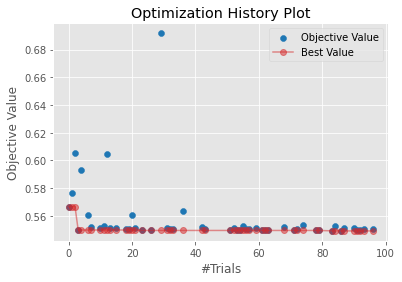

In [39]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

plot_optimization_history(study)

C:\Users\Razer\AppData\Local\Temp\ipykernel_16932\3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

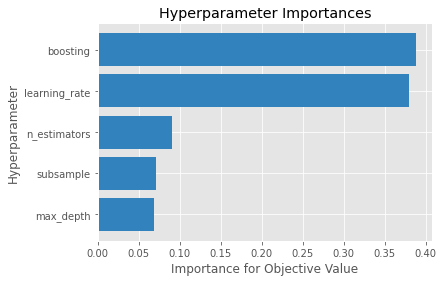

In [40]:
plot_param_importances(study)

In [61]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(n_estimators=2000, text_features=[0], colsample_bylevel=0.06, max_leaves=31, subsample=0.67, verbose=0, thread_count=6, random_state=42)
model.fit(raw_train_X.reshape(raw_train_X.shape[0], 1), train_y)
preds_class = model.predict(raw_test_X.reshape(raw_test_X.shape[0], 1))

In [62]:
preds_class

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [65]:
write_submission_file("catboost.csv", test_ids, preds_class)